In [5]:
import sys
import warnings
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from preprocess.file_manage import load_csv
from setting.paths import TRAIN_DIR, TEST_DIR
warnings.filterwarnings('ignore')

In [6]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.fc(x)
        return x


def create_graph(X, y, edge_index):
    # Convert DataFrame into a PyTorch Geometric Data object
    x = torch.tensor(X.values, dtype=torch.float)
    y = torch.tensor(y.values, dtype=torch.long).squeeze()

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    num_nodes = x.size(0)
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

    data = Data(x=x, edge_index=edge_index, y=y)
    return data


In [7]:
X_train = load_csv(f"{TRAIN_DIR}/X.csv")
y_train = load_csv(f"{TRAIN_DIR}/y.csv")
X_test = load_csv(f"{TEST_DIR}/X.csv")
y_test = load_csv(f"{TEST_DIR}/y.csv")

X_train_reshaped = pd.DataFrame(
    X_train.to_numpy().reshape(X_train.shape[0], -1))

# from LSTM
smote = SMOTE(sampling_strategy={
                0: 2000, 1: 2887, 2: 2000, 3: 2500}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)

edge_index = [[0, 1], [1, 2], [2, 3],  [2, 4]]
# each traffic situation is directly related to adjacent situations
# i.e. low-normal, normal-high...
# 2-4 due to lack of high traffic

train_data = create_graph(X_resampled, y_resampled, edge_index)
test_data = create_graph(X_test, y_test, edge_index)

model = GNNModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=4)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []
accuracy_values = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)  # Forward pass
    loss = criterion(out, train_data.y)  # Compute loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    _, predicted = torch.max(out, dim=1)
    correct = (predicted == train_data.y).sum().item()
    accuracy = correct / train_data.y.size(0)
    accuracy_values.append(accuracy)

model.eval()
with torch.no_grad():
    out = model(test_data)
    _, predicted = torch.max(out, dim=1)
    print(
        f"Classification Report: \n{classification_report(test_data.y, predicted)}")

Classification Report: 
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       148
           1       0.92      0.58      0.71       723
           2       0.34      0.71      0.47        84
           3       0.65      0.97      0.77       236

    accuracy                           0.69      1191
   macro avg       0.61      0.76      0.65      1191
weighted avg       0.78      0.69      0.70      1191



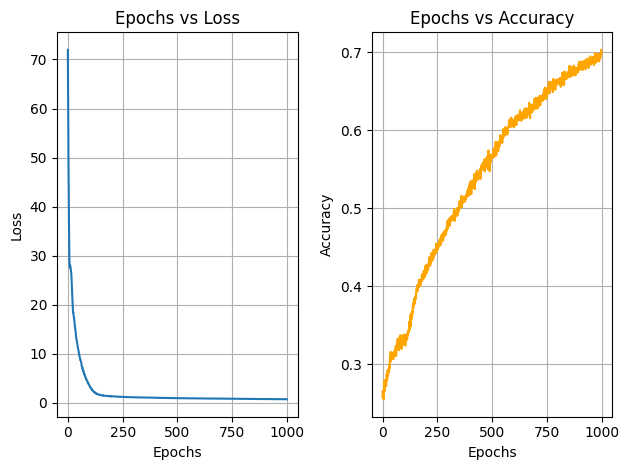

In [8]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(1000), loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1000), accuracy_values, label='Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()